In [2]:
# -*- coding: utf-8 -*-

import cv2 
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import time
from scipy.spatial import distance as dist
from pinpoint import TagList
from numba import *
import glob
sns.set_style('ticks')
%matplotlib inline
cv2.setNumThreads(0)


In [3]:
@jit(nopython = True)
def add_border(tag, tag_shape, white_width = 1, black_width = 2):
    
    """Add black and white border to barcode tag.
        
        Parameters
        ----------
        tag : 1-D array_like
            Flattened barcode tag.
        tag_shape : tuple of int
            Shape of the barcode tag without a border.
        white_width : int
            Width of white border.
        black_width : int
            Width of black border.
            
        Returns
        -------
        bordered_tag : 1-D array
            Returns tag with border added flattened to 1-D array.
        """
    
    tag = tag.reshape(tag_shape)

    black_border = np.zeros((tag_shape[0]+(2*white_width)+(2*black_width),tag_shape[1]+(2*white_width)+(2*black_width)))
    white_border = np.ones((tag_shape[0]+(2*white_width),tag_shape[1]+(2*white_width)))
    
    white_border[white_width:tag_shape[0]+white_width,white_width:tag_shape[1]+white_width] = tag
    black_border[black_width:tag_shape[0]+(2*white_width)+black_width, black_width:tag_shape[1]+(2*white_width)+black_width] = white_border

    tag = black_border
    bordered_tag = tag.reshape((1,tag.shape[0]*tag.shape[1]))
    tag_shape = black_border.shape
    return  tag_shape, bordered_tag

In [4]:
tags = TagList()
#tags.load('/Users/Jake/Google Drive/barcodes_for_fish/master_list.pkl')
tags.load('/Users/Jake/Google Drive/robust_8bit_barcodes/master_list.pkl')

master_list = tags.master_list

In [5]:
IDs = tags.id_list

In [6]:
#master_list = master_list[(161 <= IDs) & ( IDs <= 180)]
#master_list = master_list[(IDs == 163) | (IDs == 178) | (IDs == 162)]

In [7]:
#IDs = IDs[(161 <= IDs) & ( IDs <= 180)]
#IDs = IDs[(IDs == 163) | (IDs == 178) | (IDs == 162)]

In [8]:
barcode_size = (7,7)
barcodes = []
for barcode in master_list:
    tag_shape, barcode = add_border(barcode, (5,5), white_width = 1, black_width = 0)
    barcode = barcode.reshape(tag_shape)
    barcode = cv2.resize(barcode, barcode_size, interpolation = cv2.INTER_AREA)
    #plt.imshow(barcode, cmap = 'gray', interpolation = 'None')
    #plt.show()
    barcode = barcode.flatten()
    barcodes.append(barcode)
barcodes = np.array(barcodes)
#barcodes[barcodes == 0] = 0
#barcodes[barcodes == 1] = 255
barcodes

array([[ 1.,  1.,  1., ...,  1.,  1.,  1.],
       [ 1.,  1.,  1., ...,  1.,  1.,  1.],
       [ 1.,  1.,  1., ...,  1.,  1.,  1.],
       ..., 
       [ 1.,  1.,  1., ...,  1.,  1.,  1.],
       [ 1.,  1.,  1., ...,  1.,  1.,  1.],
       [ 1.,  1.,  1., ...,  1.,  1.,  1.]])

In [14]:
def crop(src, pt1, pt2):
    
    """ Returns a cropped version of src """
    
    cropped = src[pt1[1]:pt2[1], pt1[0]:pt2[0]]
    
    return cropped

@jit(nopython = True)
def distance(vector):
 
    """ Return distance of vector """

    return np.sqrt(np.sum(np.square(vector)))

@jit(nopython = True)
def _tl_right_distance(tl, right):
    D = np.empty((2))
    D[0] = distance(np.subtract(tl, right[0]))
    D[1] = distance(np.subtract(tl, right[1]))
    return D

def order_points(pts):

    """Sorts a 4x2 array of coordinates clockwise from the top-left corner.

        Parameters
        ----------
        pts : 4x2 array_like
            2-dimensional array of x,y coordinates.
            
        Returns
        -------
        ordered_pts : 4x2 array_like
            Sorted array of x,y coordinates.
        
        """

    # sort the points based on their x-coordinates
    xsorted = pts[np.argsort(pts[:, 0])]
    # grab the left-most and right-most points from the sorted
    # x-coordinate points
    left = xsorted[:2, :]
    right = xsorted[2:, :]
 
    # now, sort the left-most coordinates according to their
    # y-coordinates so we can grab the top-left and bottom-left
    # points, respectively
    left = left[np.argsort(left[:, 1]), :]
    (tl, bl) = left
 
    # now that we have the top-left coordinate, use it as an
    # anchor to calculate the Euclidean distance between the
    # top-left and right-most points; by the Pythagorean
    # theorem, the point with the largest distance will be
    # our bottom-right point
    
    D = _tl_right_distance(tl, right)
    
    (br, tr) = right[np.argsort(D)[::-1], :]
    
    # return the coordinates in clockwise order 
    # top-left, top-right, bottom-right, bottom-left 
    ordered_pts = np.array([tl, tr, br, bl], dtype="float32")

    return ordered_pts

def corr2_coeff(A,B):
    # Rowwise mean of input arrays & subtract from input arrays themeselves
    A_mA = np.subtract(A, np.mean(A, axis = 1)[:,None])
    B_mB = np.subtract(B, np.mean(B, axis = 1)[:,None])

    # Sum of squares across rows
    ssA = np.sum(np.square(A_mA), axis = 1)
    ssB = np.sum(np.square(B_mB), axis = 1)

    # Finally get corr coeff
    return np.divide(np.dot(A_mA,B_mB.T), np.sqrt(np.dot(ssA[:,None],ssB[None])))

@jit(nopython = True)
def python_corr_coeff(A,B):
    
    corr_array = np.empty((A.shape[0],1))
    
    for idx in range(A.shape[0]):
        X = A[idx]
        Y = B
        correlation_top = np.sum(np.multiply(np.subtract(X, np.mean(X)),np.subtract(Y, np.mean(Y))))
        correlation_bottom = np.multiply(np.sqrt(np.sum(np.square(np.subtract(X, np.mean(X))))), np.sqrt(np.sum(np.square(np.subtract(Y, np.mean(Y))))))
        correlation = np.divide(correlation_top, correlation_bottom)
        corr_array[idx] = correlation
        
    return corr_array

def unit_vector(vector):
	
	""" Returns the unit vector of the vector.  """
	
	return np.divide(vector, np.linalg.norm(vector))

@jit(nopython = True)
def angle(vector, degrees = False):
    x = vector[:,0]
    y = vector[:,1]
    angle = np.arctan2(y[-1] - y[0], x[-1] - x[0])
    angle = angle % (2*np.pi)
    if np.isnan(angle):
        if (vector[1] == vector[0]).all():
            angle = 0.0
        else:
            angle = 360.0
    if degrees == True:
        angle = np.degrees(angle)
    return angle

def get_grayscale(color_image, channel = None):

	""" Returns single-channel grayscale image from 3-channel BGR color image.

		Parameters
		----------
		color_image : (MxNx3) numpy array
			3-channel BGR-format color image as a numpy array
		channel : {'blue', 'green', 'red', 'none', None}, default = None
			The color channel to use for producing the grayscale image.
			None and 'none' default to cv2.cvtColor() using cv2.COLOR_BGR2GRAY. 
			Channels 'blue', 'green', and 'red' use the respective color channel as the grayscale image. 
			Channel 'green' typically provides the lowest noise, but this will depend on the lighting in the image.
			
		Returns
		-------
		gray_image : (MxNx1) numpy array
			Single-channel grayscale image as a numpy array.

	"""
	assert channel in ['blue', 'green', 'red', 'none', None], "channel must be 'blue', 'green', 'red', 'none', or None"
	assert type(color_image) == np.ndarray, "image must be a numpy array"

	image_shape = color_image.shape
	assert len(image_shape) == 3, "image must be color"
	assert color_image.shape[2] == 3, "image must have 3 color channels"
	assert color_image.dtype == np.uint8, "image array must be dtype np.uint8"

	if channel == 'blue':
		gray_image, _, _ = cv2.split(color_image)
	if channel == 'green':
			_, gray_image, _ = cv2.split(color_image)
	if channel == 'red':
		_, _, gray_image = cv2.split(color_image)
	if channel == None or channel == 'none':
		gray_image = cv2.cvtColor(color_image, cv2.COLOR_BGR2GRAY)

	return gray_image

def get_threshold(gray_image, block_size = 1001, offset = 2):

	""" Returns binarized thresholded image from single-channel grayscale image.

		Parameters
		----------
		gray_image : (MxNx1) numpy array
			Single-channel grayscale image as a numpy array
		block_size : int, default = 1001
			Odd value integer. Size of the local neighborhood for adaptive thresholding.
		offset : default = 2
			Constant subtracted from the mean. Normally, it is positive but may be zero or negative as well. 
			The threshold value T(x,y) is a mean of the block_size x block_size neighborhood of (x, y) minus offset.

		Returns
		-------
		threshold_image : (MxNx1) numpy array
			Binarized (0, 255) image as a numpy array.

	"""

	assert block_size % 2 == 1, "block_size must be an odd value"
	assert type(gray_image) == np.ndarray, "image must be a numpy array"

	assert len(gray_image.shape) == 2, "image must be grayscale"
	assert gray_image.dtype == np.uint8, "image array must be dtype np.uint8"

	threshold_image = cv2.adaptiveThreshold(gray_image, 255, cv2.ADAPTIVE_THRESH_MEAN_C, cv2.THRESH_BINARY, block_size, offset)

	return threshold_image

def get_contours(threshold_image):

	""" Returns a list of contours from a binarized thresholded image.

		Parameters
		----------
		threshold_image : (MxNx1) numpy array
			Binarized threshold image as a numpy array

		Returns
		-------
		contours : list
			List of contours extracted from threshold_image.

	"""
	assert len(set([0, 255]) - set(np.unique(threshold_image))) == 0, "image must be binarized to (0, 255)"

	_, contours, _ = cv2.findContours(threshold_image.copy(), cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)

	return contours


In [20]:
cv2.setNumThreads(0)
#pt1 = (1200,800)
#pt2 = (1700,1300)
#cap = cv2.VideoCapture("/Users/Jake/Google Drive/test.mov") 
#pt1 = (0,0)
#pt2 = (1080,1500)
#cap = cv2.VideoCapture("/Users/Jake/Google Drive/VID_20160719_103625.mp4") 
#cap = cv2.VideoCapture("/Users/Jake/Downloads/VID_20160722_115829.mp4") 
#cap = cv2.VideoCapture("/Users/Jake/Downloads/wetransfer-e18590/1471026246.44_fs_to_ffmpeg_nvenc-slow-gray.mp4") 
#cap = cv2.VideoCapture("/Users/Jake/Google Drive/20160823_170206.nvenc-ll-gray.mp4") 
#cap = cv2.VideoCapture("/Users/Jake/Google Drive/20160823_170206.nvenc-slow-yuv420-lq-gray.mp4") 
#cap = cv2.VideoCapture("/Users/Jake/Google Drive/20160824_173801.nvenc-slow-yuv420-gray.mp4") 
cap = cv2.VideoCapture("/Users/Jake/Google Drive/compression test videos/8-bit_13x13/nvenc-slow-yuv420.20160826_104737.nvenc-ll-gray.mp4") 

cap.set(cv2.CAP_PROP_POS_FRAMES,0)

#cap = cv2.VideoCapture("/Users/Jake/Downloads/GP050016.MP4") 

#cap = cv2.VideoCapture("/Users/Jake/Downloads/1471025336.83_fs_to_ffmpeg_nvenc-slow-gray.mp4") 

#cap = cv2.VideoCapture(finch_videos[1]) 
#cap = cv2.VideoCapture("/Users/Jake/Downloads/ZFichTests/GOPR0676.MP4")

#cap = cv2.VideoCapture("/Users/Jake/Google Drive/CLIP0000075_000.mov")
#pt1 = (1000,0)
#pt2 = (3160,2160)

n_frames = 0

best_values = []
area_list = []
peri_list = []
periratio_list = []
periarea_list = []
ID_list = []
#approx_list = []
matched_list = []
# Define the codec and create VideoWriter object
fourcc = cv2.VideoWriter_fourcc('A','V','C','1')
#out = cv2.VideoWriter('output.mp4',fourcc, 15.0, (1960, 1080), True)
out = cv2.VideoWriter('output.mp4',fourcc, 30.0, (2048, 2048), True)

out.set(cv2.VIDEOWRITER_PROP_QUALITY, 100)
cv2.namedWindow("Video")
cv2.namedWindow("thresh")
font = cv2.FONT_HERSHEY_SIMPLEX

flat_len = barcode_size[0]*barcode_size[1]   

maxSide = 200
length = maxSide - 1

dst = np.array([
            [0, 0],
            [length, 0],
            [length, length],
            [0, length]], dtype = "float32")

ntags_list = []
nframes_list = []
mean_best_values = []
std_best_values = []
processing_times = []
while cap.isOpened():  
    
    ret, image = cap.read()
    
    if ret:
        t0 = time.time()
        n_tags = 0
        pixel_values = []
        warped_list = []
        
        #image = crop(image, pt1, pt2)
        #cropped = cv2.resize(cropped, (0,0), None, fx = 0.33, fy = 0.33, interpolation = cv2.INTER_LINEAR)

        #image = cv2.resize(image, (0,0), None, fx = 2, fy = 2, interpolation = cv2.INTER_AREA)
        

        display_img = image.copy()

        #_, gray, _ = cv2.split(image)
        gray = get_grayscale(image, channel = 'green')
        #gray = cv2.GaussianBlur(gray, (1,1), 1)
        #thresh = cv2.adaptiveThreshold(gray, 255, cv2.ADAPTIVE_THRESH_MEAN_C, cv2.THRESH_BINARY, 1001, 0)
        thresh = get_threshold(gray, block_size = 11, offset = 8)
        #ret, thresh = cv2.threshold(gray, 150, 255, cv2.THRESH_BINARY)
        #contour_image, contours, hierarchy = cv2.findContours(thresh.copy(), cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
        contours = get_contours(thresh)
        #cv2.drawContours(display_img, contours, -1, (0,0,255), 3)
        edge_thresh = 1
        image_shape = image.shape
        maxx_thresh = image_shape[1] - edge_thresh
        maxy_thresh = image_shape[0] - edge_thresh
        
        best_values = []
        for cnt in contours:
            
            cnt_shape = cnt.shape

            if cnt_shape[0] >= 4:
                
                area = cv2.contourArea(cnt, True)

                if -30 > area > -800:
                    
                    cnt_reshape = cnt.reshape((cnt_shape[0], cnt_shape[2]))
                    cnt_x = cnt_reshape[:,0]
                    cnt_y = cnt_reshape[:,1]
                    flat = cnt.flatten()
                    edge_zero = np.sum(flat <= edge_thresh)
                    edge_maxx = np.sum(cnt_x >= maxx_thresh)
                    edge_maxy = np.sum(cnt_y >= maxy_thresh)

                    if edge_zero == 0 and edge_maxx == 0 and edge_maxy == 0:
                        
                        peri_cnt = cv2.arcLength(cnt, True)

                        approx = cv2.approxPolyDP(cnt, 0.05 * peri_cnt, True)
                    
                        #cv2.drawContours(display_img, [approx], -1, (127,0,255), 3)

                        poly_area = cv2.contourArea(approx, True)

                        if len(approx) == 4 and -30 > poly_area > -800 and cv2.isContourConvex(approx) and 10 < peri_cnt < 300:
                            peri_approx = cv2.arcLength(approx, True)

                            peri_ratio = peri_cnt/peri_approx
                            periarea = peri_cnt/area
                            
                            #cv2.drawContours(display_img, [cnt], -1, (0,0,255), 2)
                            
                            if -100 < periarea <= 0:
                            
                                cv2.drawContours(display_img, [cnt], -1, (0,255,255), 1)

                                peri_approx = cv2.arcLength(approx, True)

                                cnt_shape = approx.shape
                                pts = approx.reshape((cnt_shape[0], cnt_shape[-1]))

                                pts = order_points(pts)
                                (tl, tr, br, bl) = pts
                                
                                
                                #top = distance(tr - tl)
                                #right = distance(br - tr)
                                #bottom = distance(bl - br)
                                #left = distance(tl - bl)
                                                                
                                # compute the perspective transform matrix and then apply it
                                M = cv2.getPerspectiveTransform(pts, dst)
                                warped = cv2.warpPerspective(gray, M, (maxSide, maxSide), borderValue = 255 )
                                warped = ( warped - warped.mean() ) / warped.std()
                                warped_list.append(warped)
                                resize_warp = cv2.resize(warped, barcode_size, interpolation = cv2.INTER_AREA)
                                resize_warp = ( resize_warp - resize_warp.mean() ) / resize_warp.std()

                                pixel_values.append(resize_warp)

                                correlation = corr2_coeff(barcodes, resize_warp.reshape((1,flat_len)))
                                best_value = np.max(correlation)

                                best_values.append(best_value)
                                area_list.append(area)
                                peri_list.append(peri_cnt)
                                periratio_list.append(peri_ratio)
                                periarea_list.append(peri_cnt/area)
                                
                                if best_value > 0.75:
                                    
                                    
                                    #best_values.append(best_value)
                                    #area_list.append(area)
                                    best_index = np.argmax(correlation)

                                    ID = IDs[best_index]
                                    ID_list.append(ID)
                                    centroid = pts.mean(0)
                                    y_offset = 0
                                    x_offset = 0
                                    bottom_centroid = tuple((centroid + np.array([x_offset,-1*y_offset])).astype(int))
                                    top_centroid = tuple((centroid + np.array([x_offset,y_offset])).astype(int))
                                    mid_centroid = tuple((centroid + np.array([x_offset,0])).astype(int))
                                    centroid = tuple(centroid)

                                    rotate_test = best_index % 4

                                    if rotate_test == 3:
                                        edge = tuple(np.mean([tl, tr], axis = 0))
                                    if rotate_test == 0:
                                        edge = tuple(np.mean([tl, bl], axis = 0))
                                    if rotate_test == 1:
                                        edge = tuple(np.mean([br, bl], axis = 0))
                                    if rotate_test == 2:
                                        edge = tuple(np.mean([br, tr], axis = 0))
                                    cv2.drawContours(display_img, [approx], -1, (0,255,0), 1)

                                    #cv2.circle(display_img,tuple(pts[0]), rad, (255,0,0), -1)
                                    #cv2.circle(display_img,tuple(pts[1]), rad, (0,255,0), -1)
                                    #cv2.circle(display_img,tuple(pts[2]), rad, (0,0,255), -1)
                                    #cv2.circle(display_img,tuple(pts[3]), rad, (255,0,255), -1)

                                    #cv2.circle(display_img,centroid, rad, (0,255,0), -1)

                                    vector = np.array([centroid, edge])
                                    vector_angle = angle(vector, True)

                                    angle_str = '%.0f' % vector_angle
                                    bestval_str = '%.2f' % best_value
                                    
                                    cv2.arrowedLine(display_img, centroid, edge, (0,0,255), 1, tipLength = 0.5)

                                    font_scale = 0.5
                                    outline_font = 5
                                    inline_font = 2


                                    cv2.putText(display_img,str(ID),mid_centroid, font, font_scale,(0,0,0),outline_font,cv2.LINE_AA)
                                    cv2.putText(display_img,str(ID),mid_centroid, font, font_scale,(255,255,255),inline_font,cv2.LINE_AA)

                                    #cv2.putText(display_img,"ID: " + str(ID),top_centroid, font, font_scale,(0,0,0),outline_font,cv2.LINE_AA)
                                    #cv2.putText(display_img,"ID: " + str(ID),top_centroid, font, font_scale,(255,255,255),inline_font,cv2.LINE_AA)

                                    #cv2.putText(display_img,"O: " + angle_str, mid_centroid, font, font_scale, (0,0,0),outline_font,cv2.LINE_AA)
                                    #cv2.putText(display_img,"O: " + angle_str, mid_centroid, font, font_scale, (255,255,255),inline_font,cv2.LINE_AA)

                                    #cv2.putText(display_img,"C: " + bestval_str, bottom_centroid, font, font_scale, (0,0,0),outline_font,cv2.LINE_AA)
                                    #cv2.putText(display_img,"C: " + bestval_str, bottom_centroid, font, font_scale, (255,255,255),inline_font,cv2.LINE_AA)

                                    n_tags += 1

        pixel_values = np.array(pixel_values)
        t1 = time.time()
        dtime = t1 - t0
        processing_times.append(dtime)
        #cv2.putText(display_img,"Number of Barcodes: " + str(n_tags),(30,50), font, 1,(0,0,0),15,cv2.LINE_AA)
        cv2.putText(display_img,"Number of Barcodes: " + str(n_tags),(30,50), font, 1,(255,255,255),3,cv2.LINE_AA)
        mean_best_values.append(np.mean(best_values))
        std_best_values.append(np.std(best_values))
        ntags_list.append(n_tags)
        nframes_list.append(cap.get(cv2.CAP_PROP_POS_FRAMES))
        
        #display_img = cv2.resize(display_img, (1960,1080), None)

        #display_img = cv2.resize(display_img, (1440,810), None)
        #display_img = cv2.resize(display_img, (2048,2048), None)

        #out.write(display_img)

        display_img = cv2.resize(display_img, (1400,1400), None)

        #display_img = cv2.resize(display_img, (0,0), None, fx = 0.3, fy = 0.3)
        #thresh = cv2.resize(thresh, (0,0), None, fx = 0.3, fy = 0.3)

        #thresh = cv2.resize(thresh, (2048,2048), None)

        #thresh = cv2.resize(thresh, (1440,810), None)
        #thresh = cv2.resize(thresh, (1960,1080), None)

        #thresh = cv2.cvtColor(thresh, cv2.COLOR_GRAY2BGR)
        #display_img[-1000:,:] = thresh[:1000,:]

        
        #display_img = cv2.resize(display_img, (0,0), None, fx = 0.5, fy = 0.5, )

        cv2.imshow('Video', display_img)
        #cv2.imshow('gray', gray)
        
        #cv2.imshow("thresh", thresh)
        n_frames += 1
    elif cap.get(cv2.CAP_PROP_POS_FRAMES) == cap.get(cv2.CAP_PROP_FRAME_COUNT):
        break
    if cv2.waitKey(1) & 0xFF == 27:
        break
        
cap.release()
out.release()
cv2.destroyAllWindows()

for i in range(5):
    cv2.waitKey(1)


In [139]:
data_array = np.array([mean_best_values, std_best_values, ntags_list, processing_times, nframes_list]).T
data_array

array([[  8.45719737e-01,   4.01184449e-02,   1.56000000e+02,
          3.50338936e-01,   1.00000000e+00],
       [  8.45701495e-01,   4.01144611e-02,   1.56000000e+02,
          3.85346889e-01,   2.00000000e+00],
       [  8.45735194e-01,   4.01004959e-02,   1.56000000e+02,
          3.83723974e-01,   3.00000000e+00],
       ..., 
       [             nan,              nan,   0.00000000e+00,
          1.60843134e-01,   3.56100000e+03],
       [             nan,              nan,   0.00000000e+00,
          1.69244051e-01,   3.56200000e+03],
       [             nan,              nan,   0.00000000e+00,
          1.57210112e-01,   3.56300000e+03]])

In [140]:
import pandas as pd

In [141]:
df = pd.DataFrame(data_array, columns = ["mean_corr","std_corr", "ntags", "proc_time", "frame"])
df.to_csv("slow_yuv_420_lg30.csv", index = False)
df.head()

,mean_corr,std_corr,ntags,proc_time,frame
0,0.845720,0.040118,156.0,0.350339,1.0
1,0.845701,0.040114,156.0,0.385347,2.0
2,0.845735,0.040100,156.0,0.383724,3.0
3,0.845699,0.040099,156.0,0.411289,4.0
4,0.845114,0.040232,156.0,0.400035,5.0


In [119]:
lossless_time = []
lossy_time = []
nframes_list = []
for nframes in range(1,51):
    nframes_list.append(nframes)
    cap = cv2.VideoCapture("/Users/Jake/Google Drive/compression test videos/20160826_104737.nvenc-ll-gray.mp4") 
    t0 = time.time()

    for i in range(nframes):
        ret,image = cap.read()
    
    t1 = time.time()

    cap.release()
    lossless_time.append(t1 - t0)


    cap = cv2.VideoCapture("/Users/Jake/Google Drive/compression test videos/nvenc-slow-yuv420.20160826_104737.nvenc-ll-gray.mp4") 
    t0 = time.time()

    for i in range(nframes):
        ret,image = cap.read()
    t1 = time.time()

    cap.release()
    lossy_time.append(t1 - t0)

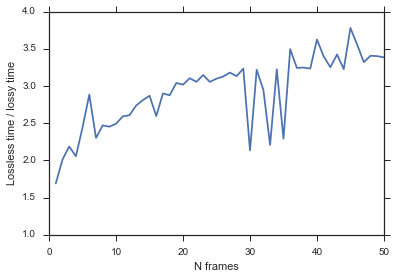

In [124]:
#plt.plot(nframes_list, lossless_time, 'g-', label = 'Lossless')
#plt.plot(nframes_list, lossy_time, 'b-', label = 'Lossy (slow-yuv420)')
plt.plot(nframes_list, np.divide(lossless_time, lossy_time))
plt.legend(loc = 'best')
plt.xlabel('N frames')
plt.ylabel('Lossless time / lossy time')
plt.savefig('lossless_vs_lossy_decode.png')
plt.ylim(1,4)
plt.show()

In [31]:
print "Frames per second: ", fps
print "Seconds processing per second of video (30 fps): ", dtime/(n_frames/30.)

Frames per second:  1.5715576797
Seconds processing per second of video (30 fps):  19.0893407143


In [180]:
rw_mean = resize_warp.mean()
resize_warp[resize_warp >= rw_mean] = 255
resize_warp[resize_warp < rw_mean] = 0

In [25]:
from skimage.segmentation import slic
from skimage.segmentation import mark_boundaries


In [43]:
segments.shape

(50, 50)

Probability of match:  0.819724919104


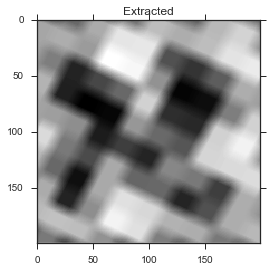

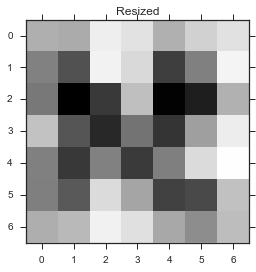

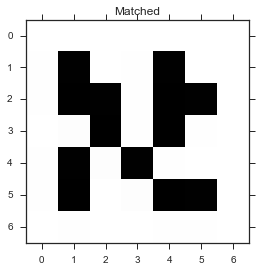

In [12]:
print "Probability of match: ", best_value
plt.imshow(warped, cmap='gray', interpolation = 'none')
plt.title("Extracted")
plt.show()
plt.imshow(resize_warp, cmap = 'gray', interpolation = 'none')
plt.title("Resized")
plt.show()
plt.imshow(barcodes[best_index].reshape(barcode_size), cmap = 'gray', interpolation = 'none')
plt.title("Matched")
plt.show()

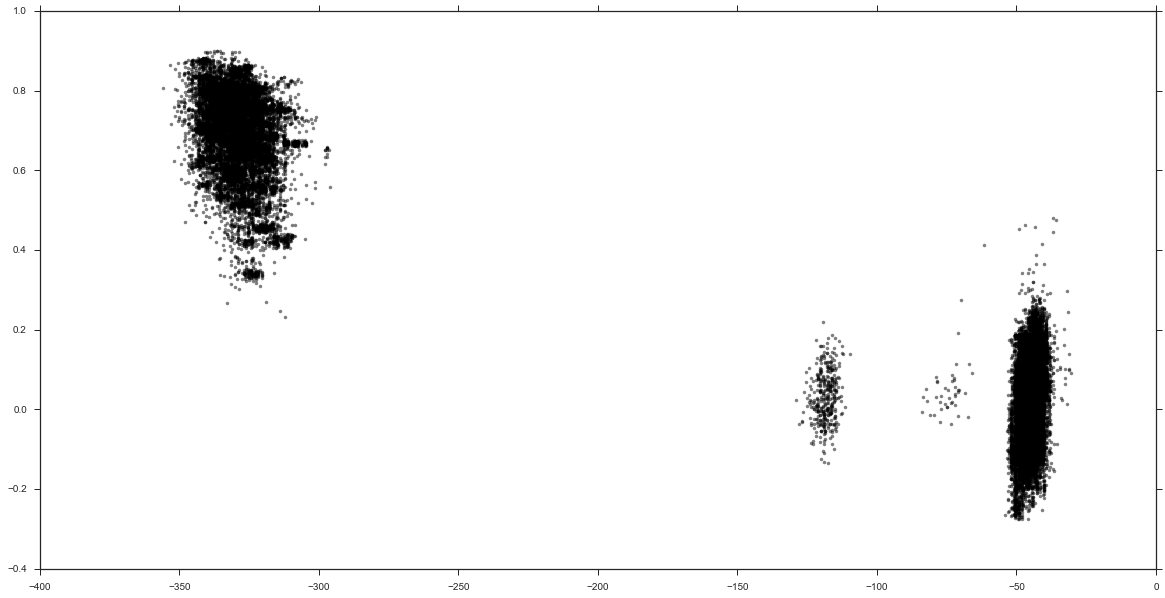

In [13]:
plt.figure(figsize = (20,10))
#plt.plot(np.arange(len(best_values)), best_values, 'k,', alpha = 0.5)
plt.plot(area_list, best_values, 'k.', alpha = 0.5)

#plt.ylim(0.5,1)
plt.show()

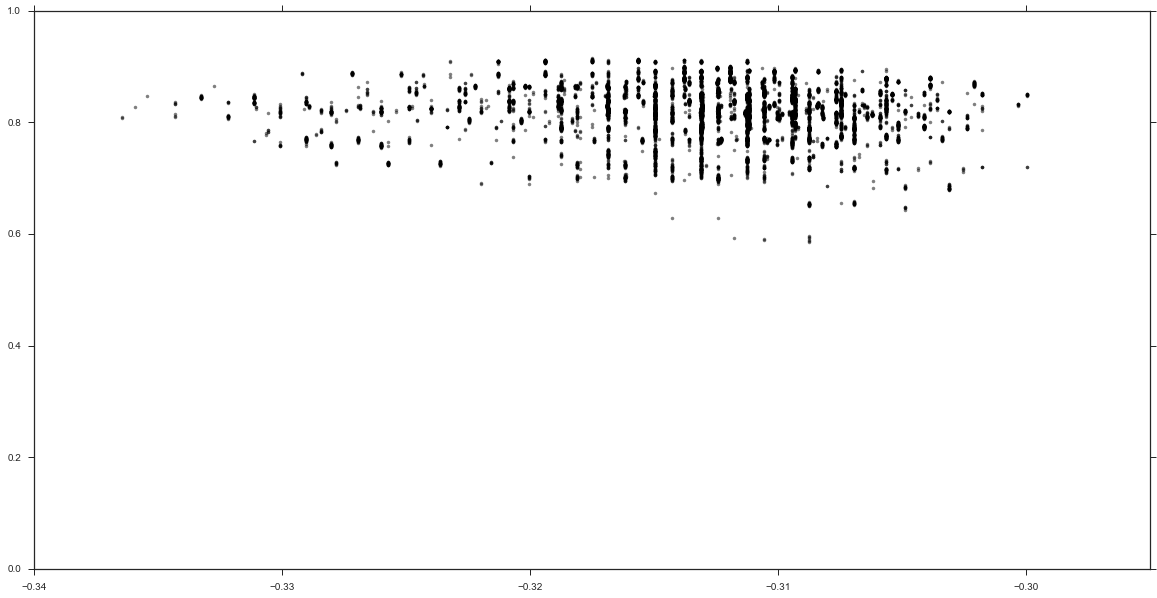

In [20]:
plt.figure(figsize = (20,10))
#plt.plot(np.arange(len(best_values)), best_values, 'k,', alpha = 0.5)
plt.plot(periarea_list, best_values, 'k.', alpha = 0.5)

plt.ylim(0,1)
#plt.xlim(-0.2, 0)
plt.show()

In [45]:
cv2.VIDEOWRITER_PROP_NSTRIPES

3

In [49]:
test_M

array([[ -1.38945470e+00,   5.76115362e-01,   2.93042773e+03],
       [ -4.80805312e-01,  -1.47675917e+00,   4.83391358e+03],
       [ -3.88761451e-04,  -5.20939322e-04,   1.00000000e+00]])

In [50]:
import math

In [59]:
def isRotationMatrix(R) :
    Rt = np.transpose(R)
    shouldBeIdentity = np.dot(Rt, R)
    I = np.identity(3, dtype = R.dtype)
    n = np.linalg.norm(I - shouldBeIdentity)
    return n < 1e-1
 
 
# Calculates rotation matrix to euler angles
# The result is the same as MATLAB except the order
# of the euler angles ( x and z are swapped ).
def rotationMatrixToEulerAngles(R) :
 
    #assert(isRotationMatrix(R))
     
    sy = math.sqrt(R[0,0] * R[0,0] +  R[1,0] * R[1,0])
     
    singular = sy < 1e-6
 
    if  not singular :
        x = math.atan2(R[2,1] , R[2,2])
        y = math.atan2(-R[2,0], sy)
        z = math.atan2(R[1,0], R[0,0])
    else :
        x = math.atan2(-R[1,2], R[1,1])
        y = math.atan2(-R[2,0], sy)
        z = 0
 
    return np.array([x, y, z])

In [60]:
print rotationMatrixToEulerAngles(test_M)

[ -5.20939275e-04   2.64411071e-04  -2.80845104e+00]


In [55]:
test_angle

162.15979856720608

In [12]:
np.unique(ID_list)

array([29, 30, 34, 35, 38, 43, 47, 50, 51, 54, 55, 58, 59])

In [45]:
tag1 = np.array([2]*15 + [1]*10).astype(np.float64)
tag2 = np.array([2]*20 + [1]*5).astype(np.float64)

In [46]:
tag1

array([ 2.,  2.,  2.,  2.,  2.,  2.,  2.,  2.,  2.,  2.,  2.,  2.,  2.,
        2.,  2.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.])

In [47]:
tag2

array([ 2.,  2.,  2.,  2.,  2.,  2.,  2.,  2.,  2.,  2.,  2.,  2.,  2.,
        2.,  2.,  2.,  2.,  2.,  2.,  2.,  1.,  1.,  1.,  1.,  1.])

In [48]:
import scipy.stats as sps

In [49]:
sps.pearsonr(tag1, tag2)

(0.61237243569579458, 0.0011389435144915914)

In [89]:
import pinpoint

In [90]:
pinpoint.__version__

'0.0.1'

In [91]:
pinpoint.__doi__

AttributeError: 'module' object has no attribute '__doi__'

In [97]:
len(set([0,255,1]) - set([255,0]))

1

In [99]:
set(np.unique([0,255]))

{0, 255}

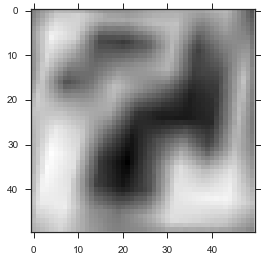

In [75]:
plt.imshow(warped, cmap='gray', interpolation = 'none')

In [43]:
distance(pts[0] - pts[1])

9.2195444

In [46]:
top

9.2195444

In [47]:
right

9.4868326

In [48]:
bottom

8.2462111

In [49]:
left

9.2195444

In [34]:
import time

In [40]:
image = np.empty((2048,2048))
pt1 = (500,500)
pt2 = (1000,1000)

def slow_crop(src, pt1, pt2):
    
    """ Returns a cropped version of src """
    
    cropped = src[pt1[1]:pt2[1], pt1[0]:pt2[0]]
    
    return cropped

n_iter = 10000000

t0 = time.time()
for i in range(n_iter):
    cropped = slow_crop(image,pt1,pt2)
t1 = time.time()
print "Pure Python runtime (s): ", (t1 - t0)#/n_iter

t0 = time.time()
for i in range(n_iter):
    cropped = fast_crop(image,pt1,pt2)
t1 = time.time()
print "Python + Numba runtime (s): ", (t1 - t0)#/n_iter

Pure Python runtime (s):  5.91849899292
Python + Numba runtime (s):  16.1293859482


In [58]:
pts

array([[ 1755.,   165.],
       [ 1764.,   170.],
       [ 1759.,   179.],
       [ 1750.,   174.]], dtype=float32)